In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

In [4]:
seasons_year = [2016, 2017, 2018, 2019]
features_data_df = FeaturesManager.build_features(seasons_year)
features_data_df.sample(10)

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Goalie,Strength,X,...,Last event st_Y,Shot distance,Shot angle,Is Goal,Is Empty,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event
25120,2016020414,227,3,Montréal Canadiens (MTL),SHOT,Wrist Shot,Daniel Carr,Calvin Pickard,NaN,-65.0,...,41.0,30.000000,-36.869898,0,0,2755,22.912828,0,0.00000,93.861600
131509,2017020905,251,3,New York Rangers (NYR),SHOT,Slap Shot,Mats Zuccarello,Alex Lyon,NaN,-65.0,...,16.0,24.738634,14.036243,0,0,2475,41.633539,0,0.00000,inf
220532,2018021084,285,3,New York Islanders (NYI),SHOT,Wrist Shot,Josh Bailey,Carey Price,NaN,59.0,...,3.0,46.861498,50.194429,0,0,2754,1.169139,0,0.00000,30.391199
174250,2018020324,113,2,Boston Bruins (BOS),SHOT,Slap Shot,Connor Clifton,Jimmy Howard,NaN,-35.0,...,-22.0,64.899923,-33.690068,0,0,1444,-11.410983,0,0.00000,5.675385
267586,2019020582,235,3,Buffalo Sabres (BUF),SHOT,Wrist Shot,Jack Eichel,Jaroslav Halak,NaN,62.0,...,-27.0,36.124784,-41.633539,0,0,3238,-8.438378,0,0.00000,14.093548
152625,2017021245,228,3,Pittsburgh Penguins (PIT),SHOT,Wrist Shot,Phil Kessel,Sergei Bobrovsky,NaN,-53.0,...,-32.0,36.345564,7.907163,0,0,2545,-10.847347,0,0.00000,10.471149
84344,2017020151,317,4,Winnipeg Jets (WPG),SHOT,Wrist Shot,Nikolaj Ehlers,Sergei Bobrovsky,NaN,80.0,...,0.0,28.460499,71.565051,0,0,3624,0.000000,0,0.00000,3.518059
129482,2017020873,265,3,Winnipeg Jets (WPG),GOAL,Wrist Shot,Bryan Little,Braden Holtby,Even,-66.0,...,22.0,26.419690,-29.475889,1,0,3090,11.410983,0,0.00000,5.803084
113443,2017020620,291,3,Montréal Canadiens (MTL),SHOT,Snap Shot,Jacob de la Rose,Andrei Vasilevskiy,NaN,-79.0,...,2.0,11.180340,26.565051,0,0,2822,0.954841,1,25.61021,12.226767
98308,2017020373,172,2,Chicago Blackhawks (CHI),SHOT,Wrist Shot,Alex DeBrincat,Pekka Rinne,NaN,-33.0,...,-36.0,123.628476,9.309940,0,0,1601,-96.340192,0,0.00000,6.565905


In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)

X = features_data_df[['Shot distance', 'Shot angle']].to_numpy().reshape(-1, 2)
y = features_data_df['Is Goal'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

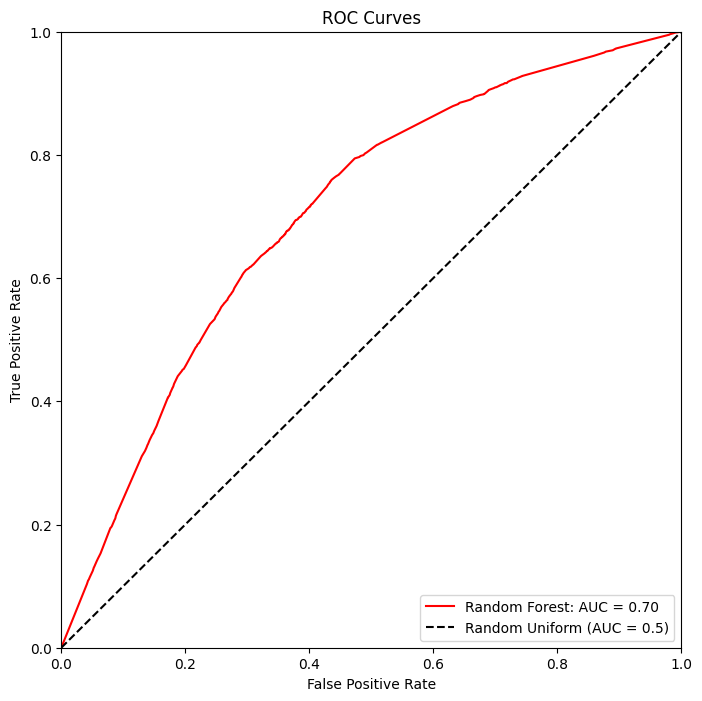

0.02459016393442623
0.027421582166107714
0.02956830277942046
0
0.031054313099041532
0.0441701851250406
0.03929273084479371
0
0.04988929889298893
0.07422852376980818
0.1017050553395154
0.09896507115135834
0.09006314390162845
0.1339712918660287
0.1423780487804878
0.18925998690242304
0.17358490566037735
0.19316712834718375
0.20108205590622183


RuntimeWarning: invalid value encountered in long_scalars

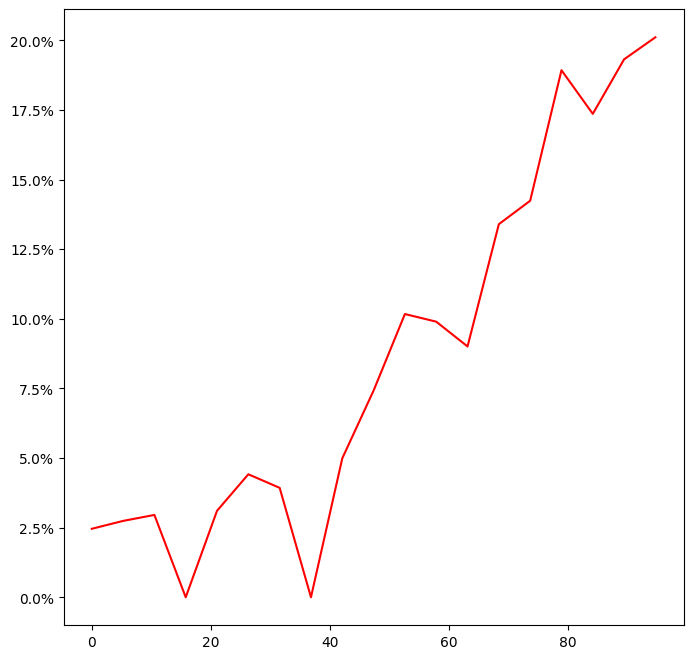

In [15]:
clf_forest =  RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)

classifiers = [(clf_forest, 'Random Forest', X_valid, y_valid)]

VizManager.plot_all_figures(classifiers, add_random=True)